## The Darcy's equation
We consider the following Darcy flows in a 2D area filled with porous materials. The governing PDE is 
$$
-\nabla( K(x,y) \nabla P(x,y)) = f(x,y), \quad x\in\Omega
$$  
where $K$ is the permeability field, $P$ is the pressure, and $f$ is a source term which can be either a constant or a space-dependent function.
### (1.1) Neural Operator learning problem

The first example of Darcy flow is defined in a rectangular domain $\Omega=[0,1]^2$ with zero Dirichlet boundary condition. We are interested in learning the mapping from the permeability field $K(x,y)$ to the pressure field $P(x,y)$, i.e.,
$$
\mathcal{G}: K(x,y) \rightarrow P(x,y)
$$

## (2) The Physics-informed DeepOnet

In [1]:
import sys 
sys.path.append("../..") 
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
random_seed = 1234
setup_seed(random_seed)
device = 'cuda:0'
dtype = torch.float32
problem_name = 'DarcyFlow_cts2d'
tag = 'fdm'
######################################
# Load training data
######################################
data_train = h5py.File('../../Problems/DarcyFlow_2d/smh_train.mat', 'r')
data_test = h5py.File('../../Problems/DarcyFlow_2d/smh_test_in.mat', 'r')
print(data_train.keys())
print(data_test.keys())
res = 29
######################################
from Utils.utils import *
n_train, n_test = 1000, 200
def get_data(data, ndata, dtype, n0=0):
    a = np2tensor(np.array(data["coeff"][...,n0:n0+ndata]).T, dtype)
    u = np2tensor(np.array(data["sol"][...,n0:n0+ndata]).T, dtype)
    beta1 = np2tensor(np.array(data["beta1"][n0:n0+ndata]), dtype)
    beta2 = np2tensor(np.array(data["beta2"][n0:n0+ndata]), dtype)
    #
    X, Y = np.array(data['X']).T, np.array(data['Y']).T
    mesh = np2tensor(np.vstack([X.ravel(), Y.ravel()]).T, dtype)
    gridx = mesh.reshape(-1, 2)
    #
    x = gridx.repeat((ndata, 1, 1))
    a = a.reshape(ndata, -1, 1)
    u = u.reshape(ndata, -1, 1)
    
    return a, u, x, gridx, beta1, beta2
#
a_train, u_train, x_train, gridx_train, beta1_train, beta2_train = get_data(data_train, n_train, dtype)
a_test, u_test, x_test, gridx_test, beta1_test, beta2_test = get_data(data_test, n_test, dtype)
#
print('The shape of x_train:', x_train.shape)
print('The shape of a_train:', a_train.shape)
print('The shape of u_train:', u_train.shape)
print('The shape of gridx_train:', gridx_train.shape)
print('The shape of beta1', beta1_train.shape, 'The shape of beta2', beta2_train.shape)
print('The shape of x_test:', x_test.shape)
print('The shape of a_test:', a_test.shape)
print('The shape of u_test:', u_test.shape)
print('The shape of gridx_test:', gridx_test.shape)
print('The shape of beta1', beta1_test.shape, 'The shape of beta2', beta2_test.shape)
######################################
# Generate mesh grids for calculating gradients
######################################
from Utils.GenPoints import Point2D
pointGen = Point2D(x_lb=[0., 0.], x_ub=[1.,1.], dataType=dtype, random_seed=random_seed)
#
N_mesh = 29
x_mesh = pointGen.inner_point(N_mesh, method='mesh')
print('x_mesh shape:', x_mesh.shape)

<KeysViewHDF5 ['X', 'Y', 'beta1', 'beta2', 'coeff', 'sol', 'soldx', 'soldy']>
<KeysViewHDF5 ['X', 'Y', 'beta1', 'beta2', 'coeff', 'sol', 'soldx', 'soldy']>
The shape of x_train: torch.Size([1000, 841, 2])
The shape of a_train: torch.Size([1000, 841, 1])
The shape of u_train: torch.Size([1000, 841, 1])
The shape of gridx_train: torch.Size([841, 2])
The shape of beta1 torch.Size([1000, 1]) The shape of beta2 torch.Size([1000, 1])
The shape of x_test: torch.Size([200, 841, 2])
The shape of a_test: torch.Size([200, 841, 1])
The shape of u_test: torch.Size([200, 841, 1])
The shape of gridx_test: torch.Size([841, 2])
The shape of beta1 torch.Size([200, 1]) The shape of beta2 torch.Size([200, 1])
x_mesh shape: torch.Size([841, 2])


### (3.2) Define the loss class and train the model 

In [2]:
###############################
# Define Loss Class
###############################
from Utils.Grad import *
import torch.nn as nn
from torch.autograd import grad, Variable

###############################
class mollifer(object):

    def __inint__(self):
        pass
        
    def __call__(self, u, x):
        u = u * torch.sin(np.pi * x[...,0:1])*torch.sin(np.pi * x[...,1:2])
        return u
        
################################
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        self.solver = solver
        self.dtype = solver.dtype
        self.device = solver.device
        self.fun_a = fun_a
        self.model_u = solver.model_dict['u']
        self.mollifer = mollifer()
        #
        self.a_train = a_train.to(self.device)
        self.u_train = u_train.to(self.device)
        self.x_train = x_train.to(self.device)
        #
        self.deltax = 1/(N_mesh-1)
        self.deltay = 1/(N_mesh-1)

    def Loss_pde(self, index, w_pde):
        if w_pde>0.:
            n_batch = index.shape[0]
            ############### Data points ###############
            x = Variable(x_mesh.repeat(n_batch, 1, 1).to(self.device), requires_grad=True)
            a = self.fun_a(x, self.a_train[index]) 
            a = a.reshape(-1, N_mesh, N_mesh, 1)
            # 
            u = self.model_u(x, self.a_train[index])
            u = self.mollifer(u, x).reshape(-1, N_mesh, N_mesh, 1)
            #
            dudx, dudy = FDM_2d(u, self.deltax, self.deltay)
            adux = a[:,1:-1,1:-1,0:1] * dudx
            aduy = a[:,1:-1,1:-1,0:1] * dudy 
            dauxdx, _ = FDM_2d(adux, self.deltax, self.deltay) 
            _, dauydy = FDM_2d(aduy, self.deltax, self.deltay) 
            #############################################
            left = (- (dauxdx + dauydy)).reshape(n_batch, -1)
            right = 10. * torch.ones_like(left)

            return self.solver.getLoss(left, right)
        else:
            return torch.tensor(0.)

    def Loss_data(self, index, w_data):
        return torch.tensor(0.)

    def Error(self, x, a, u):
        try:
            u_pred = self.model_u(x, a)
        except:
            u_pred = self.model_u(x)
        u_pred = self.mollifer(u_pred, x)
            
        return self.solver.getError(u_pred, u)

######################################
# Steups of the model
######################################
from Solvers.PIDeepONet import PIDeepONet
solver = PIDeepONet.Solver(device=device, dtype=dtype)
netType = 'DeepONetBatch'
#######################################
fun_a = solver.getModel_a(Exact_a=None, approximator='RBF', 
                          **{'x_mesh':gridx_train, 'kernel':'gaussian', 
                             'eps':25., 'smoothing':0., 'degree':6.})
####################################### The BranchNet
from Networks.CNNet import CNNet2d
class BranchNet(nn.Module):
    def __init__(self, conv_arch:list, fc_arch:list, 
                 nx_size:int, ny_size:int, dtype=None):
        super(BranchNet, self).__init__()
        self.nx_size, self.ny_size = nx_size, ny_size
        self.conv = CNNet2d(conv_arch=conv_arch, fc_arch=fc_arch,
                            activation_conv='SiLU', activation_fc='SiLU', 
                            kernel_size=(5,5), stride=2, dtype=dtype)
        
    def forward(self, x):
        x = x.reshape(-1, self.ny_size, self.nx_size).unsqueeze(1)
        x = self.conv(x)
        return x
#
conv_arch = [1, 64, 128]
fc_arch = [128*5*5, 128, 128]
branchNet = BranchNet(conv_arch, fc_arch, nx_size=res, ny_size=res, dtype=dtype)

###################################### The u model (DeepONet)
layers_branch, activation_branch = [branchNet, fc_arch[-1]], 'SiLU'
layers_trunk, activation_trunk = [2, 128, 128, 128, 128], 'ReLU'
model_u = solver.getModel(layers_branch, layers_trunk, activation_branch, activation_trunk, 
                          multi_ouput_strategy=None, num_output=1, netType=netType)
##################
total_trainable_params = sum(p.numel() for p in model_u.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

682,753 training parameters.


### (2.3) training and make prediction

#### (2.3.1) train the model

In [3]:
# Train the model
model_dict = {'u':model_u}
solver.train_setup(model_dict, lr=1e-3, optimizer='AdamW', scheduler_type='StepLR',
                   gamma=0.6, step_size=200)
solver.train_index(LossClass, a_train, u_train, x_train, a_test, u_test, x_test, 
             w_data=0., w_pde=1., batch_size=50, epochs=1000, epoch_show=50,
             **{'save_path':f'saved_models/PI{netType}_{tag}/'})

  0%|                                                                         | 0/1000 [00:00<?, ?it/s]/home/yaohua/anaconda3/envs/dnn-python309/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  5%|███▏                                                            | 50/1000 [00:38<12:10,  1.30it/s]

Epoch:50 Time:38.6833, loss:19.9182, loss_pde:19.9182, loss_data:0.0000
                l2_test:0.0657, lr:0.001


 10%|██████▎                                                        | 100/1000 [01:17<11:32,  1.30it/s]

Epoch:100 Time:77.2831, loss:15.9791, loss_pde:15.9791, loss_data:0.0000
                l2_test:0.0353, lr:0.001


 15%|█████████▍                                                     | 150/1000 [01:55<10:55,  1.30it/s]

Epoch:150 Time:115.8562, loss:13.1779, loss_pde:13.1779, loss_data:0.0000
                l2_test:0.0279, lr:0.001


 20%|████████████▌                                                  | 200/1000 [02:34<10:19,  1.29it/s]

Epoch:200 Time:154.4650, loss:11.7690, loss_pde:11.7690, loss_data:0.0000
                l2_test:0.0340, lr:0.0006


 25%|███████████████▊                                               | 250/1000 [03:13<09:39,  1.30it/s]

Epoch:250 Time:193.0620, loss:10.4945, loss_pde:10.4945, loss_data:0.0000
                l2_test:0.0237, lr:0.0006


 30%|██████████████████▉                                            | 300/1000 [03:51<09:03,  1.29it/s]

Epoch:300 Time:231.6935, loss:10.1235, loss_pde:10.1235, loss_data:0.0000
                l2_test:0.0155, lr:0.0006


 35%|██████████████████████                                         | 350/1000 [04:30<08:22,  1.29it/s]

Epoch:350 Time:270.3629, loss:9.6685, loss_pde:9.6685, loss_data:0.0000
                l2_test:0.0151, lr:0.0006


 40%|█████████████████████████▏                                     | 400/1000 [05:09<07:43,  1.29it/s]

Epoch:400 Time:309.0127, loss:8.8438, loss_pde:8.8438, loss_data:0.0000
                l2_test:0.0154, lr:0.00035999999999999997


 45%|████████████████████████████▎                                  | 450/1000 [05:47<07:05,  1.29it/s]

Epoch:450 Time:347.7105, loss:7.6501, loss_pde:7.6501, loss_data:0.0000
                l2_test:0.0116, lr:0.00035999999999999997


 50%|███████████████████████████████▌                               | 500/1000 [06:26<06:33,  1.27it/s]

Epoch:500 Time:386.9225, loss:7.9419, loss_pde:7.9419, loss_data:0.0000
                l2_test:0.0145, lr:0.00035999999999999997


 55%|██████████████████████████████████▋                            | 550/1000 [07:06<05:56,  1.26it/s]

Epoch:550 Time:426.2899, loss:7.2520, loss_pde:7.2520, loss_data:0.0000
                l2_test:0.0117, lr:0.00035999999999999997


 60%|█████████████████████████████████████▊                         | 600/1000 [07:45<05:09,  1.29it/s]

Epoch:600 Time:465.1380, loss:7.3025, loss_pde:7.3025, loss_data:0.0000
                l2_test:0.0129, lr:0.00021599999999999996


 65%|████████████████████████████████████████▉                      | 650/1000 [08:23<04:31,  1.29it/s]

Epoch:650 Time:503.9104, loss:6.5652, loss_pde:6.5652, loss_data:0.0000
                l2_test:0.0119, lr:0.00021599999999999996


 70%|████████████████████████████████████████████                   | 700/1000 [09:02<03:53,  1.28it/s]

Epoch:700 Time:542.7220, loss:6.6601, loss_pde:6.6601, loss_data:0.0000
                l2_test:0.0115, lr:0.00021599999999999996


 75%|███████████████████████████████████████████████▎               | 750/1000 [09:41<03:14,  1.29it/s]

Epoch:750 Time:581.5117, loss:6.8355, loss_pde:6.8355, loss_data:0.0000
                l2_test:0.0168, lr:0.00021599999999999996


 80%|██████████████████████████████████████████████████▍            | 800/1000 [10:20<02:35,  1.29it/s]

Epoch:800 Time:620.3471, loss:6.2411, loss_pde:6.2411, loss_data:0.0000
                l2_test:0.0129, lr:0.00012959999999999998


 85%|█████████████████████████████████████████████████████▌         | 850/1000 [10:59<01:56,  1.29it/s]

Epoch:850 Time:659.2374, loss:6.1042, loss_pde:6.1042, loss_data:0.0000
                l2_test:0.0111, lr:0.00012959999999999998


 90%|████████████████████████████████████████████████████████▋      | 900/1000 [11:38<01:17,  1.29it/s]

Epoch:900 Time:698.1098, loss:6.0556, loss_pde:6.0556, loss_data:0.0000
                l2_test:0.0119, lr:0.00012959999999999998


 95%|███████████████████████████████████████████████████████████▊   | 950/1000 [12:16<00:38,  1.31it/s]

Epoch:950 Time:736.8292, loss:6.0049, loss_pde:6.0049, loss_data:0.0000
                l2_test:0.0126, lr:0.00012959999999999998


100%|██████████████████████████████████████████████████████████████| 1000/1000 [12:55<00:00,  1.29it/s]

Epoch:1000 Time:775.3548, loss:5.9216, loss_pde:5.9216, loss_data:0.0000
                l2_test:0.0116, lr:7.775999999999999e-05
The total training time is 775.3728


### (3.3) load saved model and make prediction

The shape of a_test: torch.Size([200, 841, 1])
The shape of u_test: torch.Size([200, 841, 1]) u_pred shape torch.Size([200, 841, 1])
The test loss (avg): tensor(0.0680)
The test l2 error (avg): tensor(0.0116)


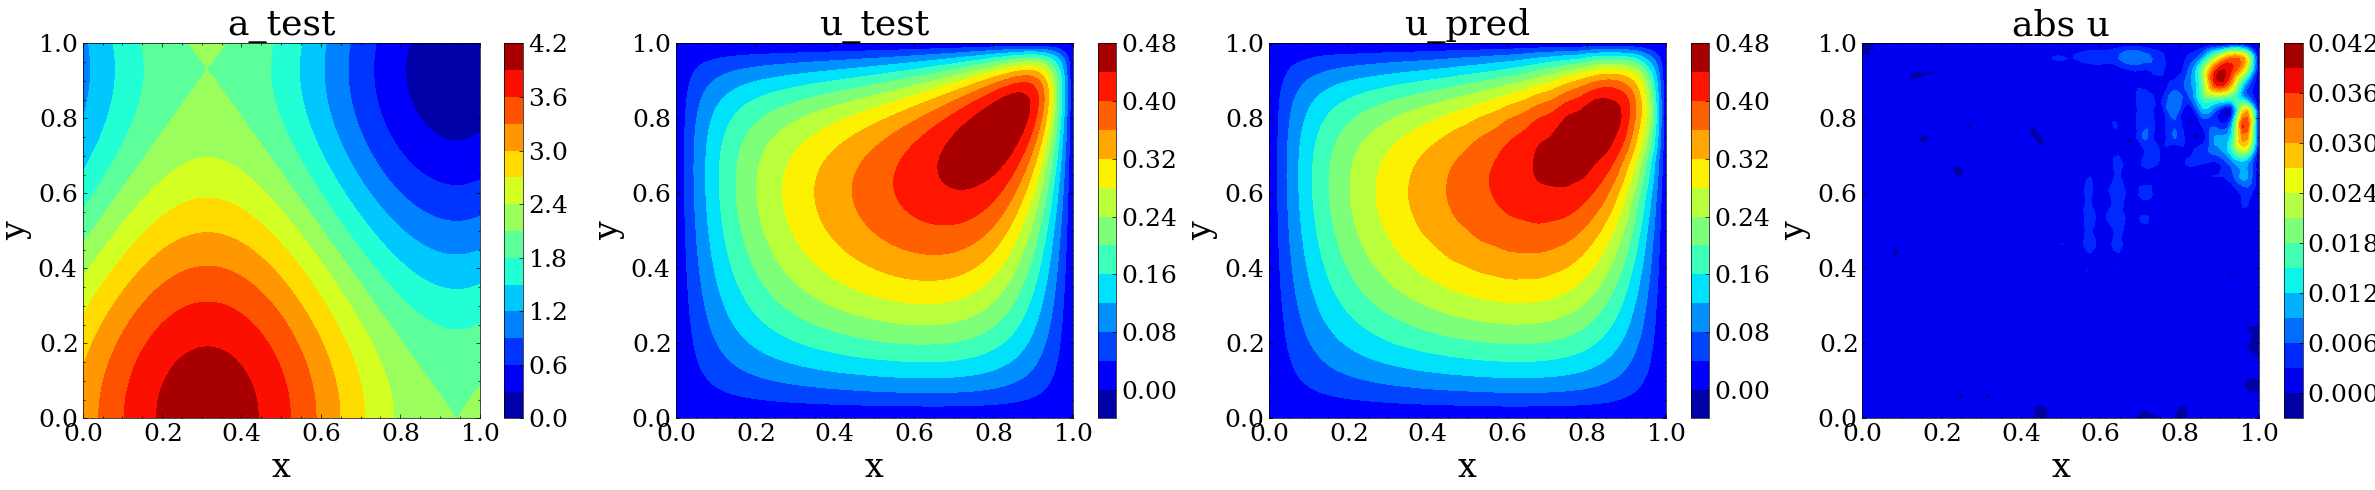

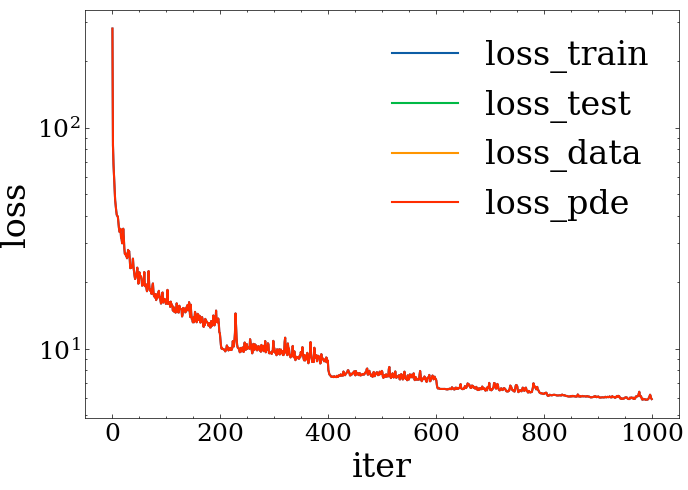

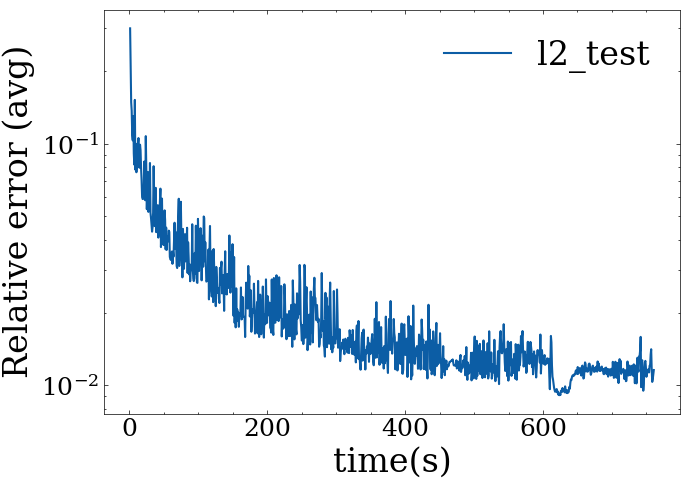

In [3]:
# #######################################
# # Load the trained model
# #######################################
from Solvers.PIDeepONet import PIDeepONet
solver = PIDeepONet.Solver(device=device, dtype=dtype)
tag = 'fdm'
model_trained = solver.loadModel(path=f'saved_models/PI{netType}_{tag}/', name=f'model_pideeponet_final')

#########################################
x_var = Variable(x_test, requires_grad=True).to(device)
try:
    a_var = model_trained['beta'](a_test.to(device))
except:
    a_var = a_test.to(device)
u_pred = model_trained['u'](x_var, a_var)
u_pred = mollifer()(u_pred, x_var).detach().cpu()
#
print('The shape of a_test:', a_test.shape)
print('The shape of u_test:', u_test.shape, 'u_pred shape', u_pred.shape)
print('The test loss (avg):', solver.getLoss(u_pred, u_test))
print('The test l2 error (avg):', solver.getError(u_pred, u_test))
inx = 0
# # ########################################
from Utils.PlotFigure import Plot
Plot.show_2d_list([gridx_train]+[gridx_test]*3, [a_test[inx], u_test[inx], u_pred[inx], torch.abs(u_test[inx]-u_pred[inx])], 
                  ['a_test', 'u_test', 'u_pred', 'abs u'], lb =0.)
#############################################
# show loss
loss_saved = solver.loadLoss(path=f'saved_models/PI{netType}_{tag}/', name='loss_pideeponet')
Plot.show_loss([loss_saved['loss_train'], loss_saved['loss_test'], loss_saved['loss_data'], loss_saved['loss_pde']], 
               ['loss_train', 'loss_test', 'loss_data', 'loss_pde'])
# show error
Plot.show_error([loss_saved['time']]*1, [loss_saved['error']], ['l2_test'])